In [104]:
import numpy as np
from numpy import linalg
import pandas as pd
import matplotlib.pyplot as plt
import statistics as st
from PIL import Image

In [105]:
imagem = Image.open('CD.png')
imagem = imagem.convert('L')
imagem = np.array(imagem)


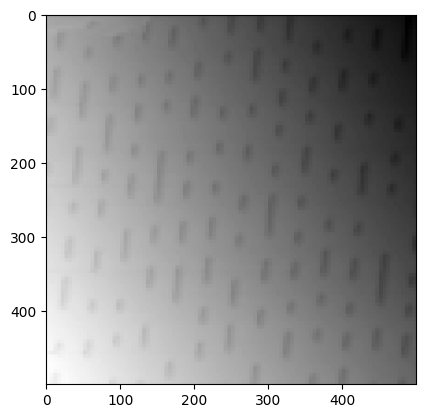

In [106]:
plt.imshow(imagem, cmap='gray')

In [107]:
def desentortar(imagem_qualquer):
    x, y = np.meshgrid(np.arange(imagem_qualquer.shape[1]), np.arange(imagem_qualquer.shape[0]))
    A = np.vstack((x.ravel(), y.ravel(), np.ones(x.size))).T
    B = imagem_qualquer.ravel()
    fit = np.linalg.lstsq(A, B, rcond=None)[0]
    plano_de_fundo = fit[0] * x + fit[1] * y + fit[2]

    imagem_nivelada = imagem_qualquer - plano_de_fundo
    
    return imagem_nivelada, plano_de_fundo

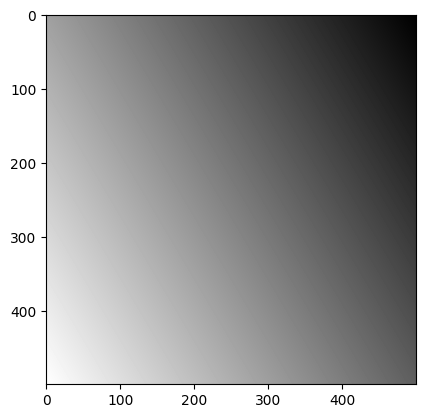

In [108]:
fundo = desentortar(imagem)[1]

plt.imshow(fundo, cmap='gray')

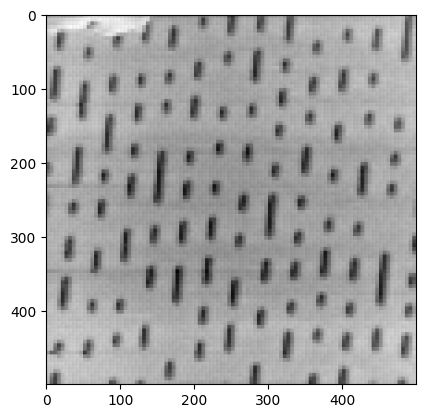

In [109]:
desentortada = desentortar(imagem)[0]

plt.imshow(desentortada,cmap='gray')

In [110]:
def normalizar(matriz_qualquer):
    max_antigo = matriz_qualquer.max()
    min_antigo = matriz_qualquer.min()
    max_novo = 255
    min_novo = 0
    
    matriz_normalizada = (matriz_qualquer - min_antigo) * (max_novo - min_novo) / (max_antigo - min_antigo) + min_novo
    return matriz_normalizada

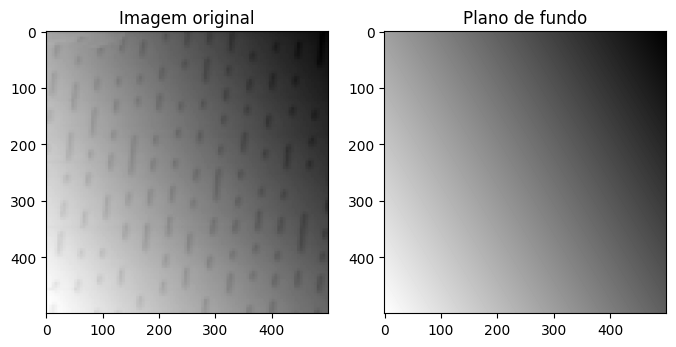

In [111]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

# Exibe a primeira imagem na primeira subtrama.
axs[0].imshow(imagem, cmap= 'gray')
axs[0].set_title('Imagem original')

# Exibe a segunda imagem na segunda subtrama.
axs[1].imshow(fundo, cmap= 'gray')
axs[1].set_title('Plano de fundo')

plt.show()


In [112]:
plano_normal = normalizar(desentortada)

In [119]:
def filtro_mediana(imagem_qualquer):
    
    plano_de_medianas = np.zeros((imagem_qualquer.shape[0], imagem_qualquer.shape[1]))
    for i in range(imagem_qualquer.shape[0]):
        mediana = np.median(imagem_qualquer[i])
        for j in range(imagem_qualquer.shape[1]):
            plano_de_medianas[i][j] = mediana 

    imagem_filtrada = imagem_qualquer - plano_de_medianas
    
    return imagem_filtrada

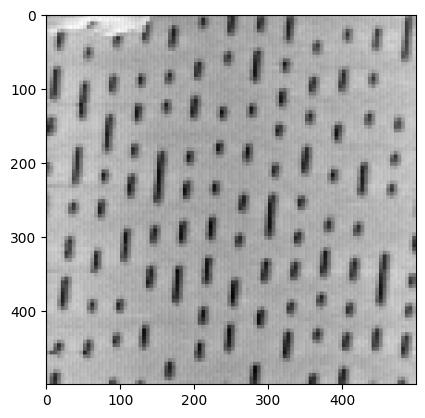

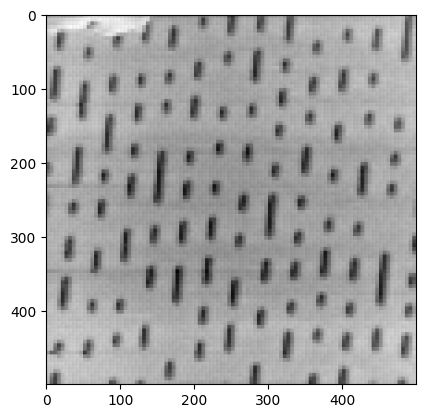

In [120]:

aaaaa = filtro_mediana(plano_normal)

plt.imshow(aaaaa,cmap='gray')
plt.show()
plt.imshow(plano_normal,cmap='gray')

In [ ]:
def colorindo(imagem_cinza, matriz_cor):
    
    if matriz_cor.shape[0] != 3:
        return('Falha')
    
    cor_normalizada = matriz_cor/matriz_cor.max()
    
    
    linhas, colunas = imagem_cinza.shape
    matriz_colorida = np.empty((linhas, colunas, 3), dtype=int) 

    for i in range(linhas):
        for j in range(colunas):
            matriz_colorida[i, j] = imagem_cinza[i, j] * cor_normalizada
            
    
    
    return matriz_colorida



Text(0.5, 1.0, 'Imagem colorida')

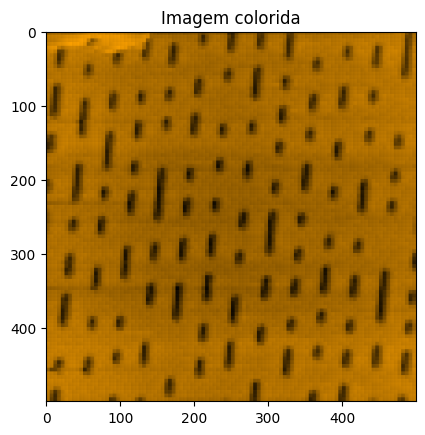

In [ ]:
cor = np.array([238,152,0])

colorida = colorindo(plano_normal, cor)
plt.imshow(colorida)
plt.title('Imagem colorida')

In [ ]:
import numpy as np

def filtro_mediana(matrix_qualquer):
    for i in range(matrix_qualquer.shape[])
    
    


In [ ]:
filtrada = colorindo(filtro_mediana(plano_normal,2),cor)

fig, axs = plt.subplots(1, 2, figsize=(8, 4))

# Exibe a primeira imagem na primeira subtrama.
axs[0].imshow(colorida)
axs[0].set_title('Imagem 1')

# Exibe a segunda imagem na segunda subtrama.
axs[1].imshow(filtrada)
axs[1].set_title('Imagem 2')

ValueError: O tamanho da janela deve ser ímpar.

In [ ]:
plano_normal

array([[152.66380331, 154.99221402, 157.32062472, ..., 160.95494981,
        163.28336052, 165.61177123],
       [151.28500209, 153.6134128 , 155.94182351, ..., 159.57614859,
        161.9045593 , 164.23297001],
       [149.90620087, 152.23461158, 154.56302229, ..., 158.19734737,
        160.52575808, 162.85416879],
       ...,
       [169.03561277, 171.36402348, 173.69243418, ..., 194.86765965,
        197.19607036, 199.52448106],
       [167.65681155, 169.98522226, 172.31363297, ..., 193.48885843,
        195.81726914, 198.14567984],
       [166.27801033, 168.60642104, 170.93483175, ..., 192.11005721,
        194.43846792, 196.76687862]])

[1] Como converter imagens em array NumPy? – Acervo Lima. Disponível em: <https://acervolima.com/como-converter-imagens-em-array-numpy/>. Acesso em: 23 set. 2023.

[2‌] Como remover elementos específicos de uma array NumPy? – Acervo Lima. Disponível em: <https://acervolima.com/como-remover-elementos-especificos-de-uma-array-numpy/>. Acesso em: 23 set. 2023.

‌